<a href="https://colab.research.google.com/github/docuracy/desCartes/blob/main/data/spectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Vector Extraction Project Framework

## 1. Initial Data Preparation

### Annotate fully orthogonal rectangular areas using [QGIS](https://www.qgis.org/en/site/)

* Set project CRS to EPSG:3857.
* Configure project snapping settings.
* Select scale for maximum magnification (e.g. 1:3390 for zoom level 16). The Magnifier control can be used to facilitate annotation.
* Add template GeoPackage from [here](https://drive.google.com/file/d/1-61VwwLWoeOGk4lsfRx620aFJwrXkCE1/view?usp=sharing).
* Enable editing in the `regions` layer, and using the "Add Rectangle from Extent" tool (Shape Digitizing Toolbar) draw the region(s) that you wish to annotate.
* Open the labels-regions attribute table and add the XYZ URL for the basemap which is to be annotated (see [National Library of Scotland](https://maps.nls.uk/guides/georeferencing/qgis/) for examples). Indicate in the `annotated` column whether or not the region is to be annotated (otherwise it will be used for testing).
* Fully annotate every road and path within each `annotated` region, paying particular attention to the location of junctions. Lines that meet or cross the boundary of a region should be extended a little way beyond that boundary. Use the following codes to distinguish between different types of road or path, dividing them into sections if necessary (descriptions below apply to OS 6" maps):
** 1: Main road (parallel thick and thin lines)
** 2: Minor road (parallel thin lines)
** 3: Semi-enclosed path (parallel solid and dashed lines)
** 4: Unenclosed path (parallel dashed lines)

## 2. Train [Ilastik](https://www.ilastik.org/) Pixel Classifier

### Not necessary if you intend to work with 6" Ordnance Survey maps

* Use the `Generate & Augment Training Data` cell below to fetch map tiles and to create from them geotiffs covering the rectangular areas covered by your annotations.
* Train Ilastik to classify background, roads, and other features.






In [1]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#@title Initialise directories and global variables

import os
import sys
import subprocess
from collections import defaultdict

# Directory containing scripts such as 'map_from_tiles'
scripts_directory = '/content/drive/MyDrive/Colab Notebooks/scripts'
sys.path.append(scripts_directory)

# Directories used by 'map_from_tiles'
temp_directory = f"{scripts_directory}/temp"
cache_directory = f"{scripts_directory}/data/cache"

training_data_directory = '/content/drive/MyDrive/desCartes/training_data/'
map_directory = f"{training_data_directory}maps/"
map_classified_s1_directory = f"{map_directory}classified_s1/"
map_one_inch_directory = f"{map_directory}one_inch/"
map_osm_directory = f"{map_directory}osm/"
map_dem_directory = f"{map_directory}dem/"
map_elevation_directory = f"{map_dem_directory}elevation/"
map_slope_directory = f"{map_dem_directory}slope/"
map_augmented_s1_directory = f"{map_directory}augmented_s1/"
map_binary_directory = f"{map_directory}binary/"
map_skeleton_directory = f"{map_directory}skeleton/"
map_output_directory = f"{map_directory}output/"
map_mask_directory = f"{map_output_directory}masks/"
map_overlay_directory = f"{map_output_directory}overlays/"
map_geotiff_directory = f"{map_output_directory}geotiffs/"
labels_directory = f"{map_directory}labels/"
labels_raster_directory = f"{labels_directory}raster/"
labels_overlay_directory = f"{labels_directory}overlay/"

tile_directory = f"{training_data_directory}tiles/"
tile_size = 512 # (px) - matches the dimensions expected by the SegFormer transformer
min_overlap = 16 # Minimum tile overlap (px)

# GeoPackage containing map annotations created in QGIS
geopackage_path = '/content/drive/MyDrive/desCartes/templates/labels.gpkg'
linestring_buffer = 3 # (px) Use False for no buffer

maptiler_key = 'U2vLM8EbXurAd3Gq6C45'

# UK Great Britain, Ordnance Survey six-inch to the mile (1:10,560), 1888-1913 https://cloud.maptiler.com/tiles/uk-osgb10k1888/
basemap_url = 'https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg' + f'?key={maptiler_key}'

# UK Great Britain, Ordnance Survey one-inch to the mile (1:63,360), 1888-1913 https://cloud.maptiler.com/tiles/uk-osgb63k1885/
basemap_url_one_inch = 'https://api.maptiler.com/tiles/uk-osgb63k1885/{z}/{x}/{y}.png' + f'?key={maptiler_key}'

# DEM Tiles - see https://documentation.maptiler.com/hc/en-us/articles/4405444055313-RGB-Terrain-by-MapTiler
dem_tilesource = 'https://api.maptiler.com/tiles/terrain-rgb-v2/{z}/{x}/{y}.webp' + f'?key={maptiler_key}'
dem_max_zoom = 14

# Ilastik model used for Stage 1 pixel classification
ilastik_project_file = "/content/drive/MyDrive/desCartes/ilastik/preprocess.ilp"
ilastik_executable = './ilastik-1.4.0-Linux/run_ilastik.sh'

# Directory for saving trained models
model_directory = "/content/drive/MyDrive/desCartes/models"

label_strings_file = os.path.join(model_directory, 'label_strings.txt')
class_weights_file = os.path.join(model_directory, 'class_weights.json')
num_classes = 5 # Allows for fill (zero) and road classes 1 to 4 (determined by QGIS labelling)
class_poll = defaultdict(dict)

# Google Cloud Services
gcs_key_path = '/content/drive/MyDrive/desCartes/descartes-404713-cccf7c3921aa.json'
gcs_project_id = 'descartes-404713'
gcs_bucket_name = 'descartes'
gcs_data_directory = "training_data"

# Set the split ratios and batch size for training data
PyTorch_batch_size = 1
train_ratio = 0.85
eval_ratio = 0.15

initial_learning_rate = 0.0001

# Inference: Color mappings for classes
class_colors = {
    0: (0, 0, 0, 0),  # Transparent (background)
    1: (178,24,43,180),  # Red
    2: (239,138,98,180),  # Orange
    3: (84,39,136,180),  # Purple
    4: (153,142,195,180),  # Lilac
}

# Create directories if they do not exist
directories_to_create = [
    temp_directory,
    cache_directory,
    training_data_directory,
    map_directory,
    map_one_inch_directory,
    map_osm_directory,
    map_dem_directory,
    map_elevation_directory,
    map_slope_directory,
    map_classified_s1_directory,
    map_augmented_s1_directory,
    map_binary_directory,
    map_skeleton_directory,
    map_output_directory,
    map_mask_directory,
    map_overlay_directory,
    map_geotiff_directory,
    labels_directory,
    labels_raster_directory,
    labels_overlay_directory,
    model_directory,
]

for directory in directories_to_create:
    os.makedirs(directory, exist_ok=True)

def install_ilastik(): # Install only if/when needed
    subprocess.run(['wget', 'https://files.ilastik.org/ilastik-1.4.0-Linux.tar.bz2'])
    subprocess.run(['tar', 'xjf', 'ilastik-1.4.0-Linux.tar.bz2'])
    subprocess.run(['rm', './ilastik-1.4.0-Linux.tar.bz2'])
    sys.path.append('/content/ilastik-1.4.0-Linux/lib/python3.7/site-packages')


In [ ]:
#@title Load tile-fetching code

'''
map_from_tiles.py

@author: Stephen Gadd, Docuracy Ltd, UK
Adapted from https://github.com/jimutt/tiles-to-tiff

This script is used to create a georeferenced map from a tile source. It uses
the GDAL library to fetch, georeference and merge tiles of an image. The script
takes in the tile source, output directory, map name, bounding box and
zoom level as input. The bounding box is used to calculate the range of x and
y coordinates of the tiles that need to be fetched. Once all the tiles are
fetched, they are georeferenced and merged to create a single map file.

'''

import urllib.request
import os
from io import BytesIO
from PIL import Image
import glob
import shutil
from osgeo import gdal
import pyproj as proj
import hashlib
import base64
from math import log, tan, radians, cos, pi, floor, degrees, atan, sinh

gdal_options = {
    'jpg': {'format': 'JPEG', 'creationOptions': ['PIXELTYPE=U8', 'JPEG_QUALITY=100', 'JPEG_SUBSAMPLE=0', 'PROGRESSIVE=NO']},
    'webp': {'format': 'WEBP', 'creationOptions': ['RESAMPLING=NEAREST','QUALITY=100']},
    'png': {'format': 'PNG', 'creationOptions': ['COMPRESS=DEFLATE', 'ZLEVEL=9']},
    'tif': {'format': 'GTiff', 'creationOptions': None}
    }

def sec(x):
    return(1/cos(x))


def latlon_to_xyz(lat, lon, z):
    tile_count = pow(2, z)
    x = (lon + 180) / 360
    y = (1 - log(tan(radians(lat)) + sec(radians(lat))) / pi) / 2
    return(tile_count*x, tile_count*y)


def bbox_to_xyz(lon_min, lon_max, lat_min, lat_max, z):
    x_min, y_max = latlon_to_xyz(lat_min, lon_min, z)
    x_max, y_min = latlon_to_xyz(lat_max, lon_max, z)
    return(floor(x_min), floor(x_max),
           floor(y_min), floor(y_max))


def mercatorToLat(mercatorY):
    return(degrees(atan(sinh(mercatorY))))


def y_to_lat_edges(y, z):
    tile_count = pow(2, z)
    unit = 1 / tile_count
    relative_y1 = y * unit
    relative_y2 = relative_y1 + unit
    lat1 = mercatorToLat(pi * (1 - 2 * relative_y1))
    lat2 = mercatorToLat(pi * (1 - 2 * relative_y2))
    return(lat1, lat2)


def x_to_lon_edges(x, z):
    tile_count = pow(2, z)
    unit = 360 / tile_count
    lon1 = -180 + x * unit
    lon2 = lon1 + unit
    return(lon1, lon2)


def tile_edges(x, y, z):
    lat1, lat2 = y_to_lat_edges(y, z)
    lon1, lon2 = x_to_lon_edges(x, z)
    return[lon1, lat1, lon2, lat2]


def fetch_tile(x, y, z, tile_source, cache_dir, temp_dir, filetype):

    cache_path = f'{cache_dir}/{x}_{y}_{z}.{filetype}'
    if os.path.exists(cache_path):
        shutil.copy(cache_path, temp_dir)
        return cache_path

    url = tile_source.replace(
        "{x}", str(x)).replace(
        "{y}", str(y)).replace(
        "{z}", str(z)).replace(
        "%7Bx%7D", str(x)).replace(
        "%7By%7D", str(y)).replace(
        "%7Bz%7D", str(z))

    if not tile_source.startswith("http"):
        return url.replace("file:///", "")

    path = f'{temp_dir}/{x}_{y}_{z}.{filetype}'

    req = urllib.request.Request(
        url,
        data=None,
        headers={
            'User-Agent': 'desCartes (+https://github.com/docuracy/desCartes)'
        }
    )
    g = urllib.request.urlopen(req)

    if filetype == 'webp': # Convert to png to avoid band distortion at georeferencing stage
        webp_image = Image.open(BytesIO(g.read()))
        png_image_path = path.replace(".webp", ".png")
        webp_image.save(png_image_path, format="PNG")
        return png_image_path

    elif filetype == 'png': # Remove alpha channel to avoid distortion at mosaicing stage
        png_image = Image.open(BytesIO(g.read()))
        png_image.convert('RGB').save(path, format="PNG")
        return path

    else:
        with open(path, 'b+w') as f:
            f.write(g.read())
        return path

def merge_tiles(input_pattern, output_path, extent, crs, temp_dir, filetype):

    input_files = glob.glob(input_pattern)
    if not input_files:
        print(f"No files found matching pattern: {input_pattern}")
        return

    print(gdal_options[filetype])

    vrt_path = os.path.join(temp_dir, "tiles.vrt")
    gdal.BuildVRT(vrt_path, input_files, addAlpha=False)
    print(f'Projecting {extent} to {crs}')
    gdal.Translate(
        output_path,
        vrt_path,
        outputSRS=crs,
        projWin=[extent[0], extent[3], extent[2], extent[1]],
        format=gdal_options[filetype]['format'],
        creationOptions=gdal_options[filetype]['creationOptions'],
        # resampleAlg='cubic'
    )

def georeference_raster_tile(x, y, z, path, crs, temp_dir, filetype, tilesize):
    bounds = tile_edges(x, y, z)

    # Create the projection transformer and transform from EPSG:4326
    transformer = proj.Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    bounds[0],bounds[1] = transformer.transform(bounds[0], bounds[1])
    bounds[2],bounds[3] = transformer.transform(bounds[2], bounds[3])

    # Save the original tile to a temporary file
    original_tile_path = os.path.join(temp_dir, f'original_{x}_{y}_{z}.{filetype}')
    shutil.copy(path, original_tile_path)

    gdal.Translate(os.path.join(temp_dir, f'{temp_dir}/{x}_{y}_{z}.{filetype}'),
           original_tile_path,
           outputSRS=crs,
           outputBounds=bounds,
           width=tilesize['x'],
           height=tilesize['y'],
           format=gdal_options[filetype]['format'],
           creationOptions=gdal_options[filetype]['creationOptions'],
           )

    os.remove(original_tile_path)

def create_map(tile_source, output_dir, map_name, bounding_box, zoom, crs, temp_dir, cache_dir_root, filetype='jpg'):

    filetype = tile_source.split('.')[-1].split('?')[0]

    bounding_box_original = bounding_box

    if not crs == 'EPSG:4326':

        # Create the projection transformer to EPSG:4326
        transformer = proj.Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

        # Extract the coordinates of the extent
        xminOld, yminOld, xmaxOld, ymaxOld = bounding_box

        # Use the transformer to convert the extent
        xmin4326, ymin4326 = transformer.transform(xminOld, yminOld)
        xmax4326, ymax4326 = transformer.transform(xmaxOld, ymaxOld)

        bounding_box = (xmin4326, ymin4326, xmax4326, ymax4326)

    # Print the extent
    print(f"Extent of {map_name}: {bounding_box}")

    lon_min, lat_min, lon_max, lat_max = bounding_box

    # Create a cache directory name
    hash_obj = hashlib.sha256(tile_source.encode())
    hash_bytes = hash_obj.digest()
    hash_b64 = base64.urlsafe_b64encode(hash_bytes).decode()
    cache_dir = os.path.join(cache_dir_root, hash_b64)

    # Script start:
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    x_min, x_max, y_min, y_max = bbox_to_xyz(
        lon_min, lon_max, lat_min, lat_max, zoom)

    total_tiles = (x_max - x_min + 1) * (y_max - y_min + 1)
    counter = 0
    tilesize = None
    print(f"Fetching & georeferencing {total_tiles} tiles...")

    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            counter += 1
            try:
                tile_path = fetch_tile(x, y, zoom, tile_source, cache_dir, temp_dir, filetype)
                if filetype == 'webp': # (Converted by fetch_tile)
                    filetype = 'png'
                percent_done = counter / total_tiles * 100
                print(f"{percent_done:.1f}% : {x},{y} {'found in cache.' if cache_dir in tile_path else 'fetched from tileserver.'}", end='\r')
                if tilesize is None:
                    print(f'Fetching tile size of {tile_path}...')
                    ds = gdal.Open(tile_path)
                    tilesize = {'x': ds.RasterXSize, 'y': ds.RasterYSize}
                    ds = None
                    print(f'... {tilesize}')
                georeference_raster_tile(x, y, zoom, tile_path, crs, temp_dir, filetype, tilesize)
            except OSError:
                print(f"Error, failed to get {x},{y}")
                pass

    if tilesize is None:
        print("Failed to fetch any tiles for this extent.")
        filename = None

    else:

        print("Resolving and georeferencing of raster tiles complete.")

        print("Merging tiles ...")
        filename = os.path.join(output_dir, map_name)
        merge_tiles(os.path.join(temp_dir, f'*.{filetype}'), filename, bounding_box_original, crs, temp_dir, filetype)
        print("... complete")

        # Move any downloaded files to the cache folder
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        for file in os.listdir(temp_dir):
            if file.endswith(f'.{filetype}'):
                shutil.move(os.path.join(temp_dir, file), os.path.join(cache_dir, file))

    shutil.rmtree(temp_dir)

    return filename


In [ ]:
#@title Create maps from tiles

#from map_from_tiles import create_map

import geopandas as gpd
import os

include_DEM = True # @param {type:"boolean"}

if include_DEM:
    from PIL import Image
    import numpy as np
    from osgeo import gdal
    import matplotlib.pyplot as plt

    # Check if richdem is installed
    try:
        import richdem as rd
    except ImportError:
        !pip install richdem
        import richdem as rd

# Open the GeoPackage
regions_gdf = gpd.read_file(geopackage_path, layer='regions')
crs = regions_gdf.crs

# Loop through each region in the GeoDataFrame
for index, row in regions_gdf.iterrows():
    # Extract the region name, URL, and other attributes
    region_name = row['name']
    geom = row['geometry']

    # Get the extent (bounding box) of the geometry
    extent = geom.bounds

    map_filename = f"{region_name}.jpg"
    map_path = os.path.join(map_directory, map_filename)
    # Check if the map file already exists
    if not os.path.exists(map_path):
        # If it doesn't exist, create the map
        map_path = create_map(basemap_url, map_directory, map_filename, extent, 17, crs, temp_directory, cache_directory)
    else:
        print(f"The map for '{region_name}' already exists at '{map_directory}'. Skipping map creation.")

    map_one_inch_filename = f"{region_name}.png"
    map_one_inch_path = os.path.join(map_one_inch_directory, map_one_inch_filename)
    # Check if the map file already exists
    if not os.path.exists(map_one_inch_path):
        # If it doesn't exist, create the map
        map_one_inch_path = create_map(basemap_url_one_inch, map_one_inch_directory, map_one_inch_filename, extent, 16, crs, temp_directory, cache_directory)
    else:
        print(f"The one-inch map for '{region_name}' already exists at '{map_one_inch_directory}'. Skipping map creation.")

    if include_DEM:
        filetype = dem_tilesource.split('.')[-1].split('?')[0]
        if filetype == 'webp':
            filetype = 'png'
        map_elevation_filename = f"{region_name}_elevation.{filetype}"
        map_elevation_path = os.path.join(map_elevation_directory, map_elevation_filename)
        # Check if the map elevation file already exists
        if not os.path.exists(map_elevation_path):
            map_elevation_path = create_map(dem_tilesource, map_elevation_directory, map_elevation_filename, extent, dem_max_zoom, crs, temp_directory, cache_directory, filetype)
        else:
            print(f"The elevation map for '{region_name}' already exists at '{map_elevation_directory}'. Skipping map elevation creation.")

        map_slope_filename = f"{region_name}_slope.npy"
        map_slope_path = os.path.join(map_slope_directory, map_slope_filename)
        # Check if the map slope file already exists
        if not os.path.exists(map_slope_path):

            # Rather convoluted due to difficulty in persuading richdem to load data any other way

            # Open the original map image with GDAL
            map_ds = gdal.Open(map_path)
            map_width = map_ds.RasterXSize
            map_height = map_ds.RasterYSize

            # Open the elevation image with GDAL
            elevation_ds = gdal.Open(map_elevation_path)

            # Read the RGB values from the GDAL dataset
            r_band = elevation_ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
            g_band = elevation_ds.GetRasterBand(2).ReadAsArray().astype(np.float32)
            b_band = elevation_ds.GetRasterBand(3).ReadAsArray().astype(np.float32)

            print(f"Red: {np.min(r_band)} to {np.max(r_band)} ({np.mean(r_band)}); Green: {np.min(g_band)} to {np.max(g_band)} ({np.mean(g_band)}); Blue: {np.min(b_band)} to {np.max(b_band)} ({np.mean(b_band)}); ")

            # Convert RGB values to elevation in npy array
            elevation_map = np.array(-10000 + ((r_band * 256 * 256 + g_band * 256 + b_band) * .1)).astype(np.float32)
            ## -10000 + ((red * 256 * 256 + green * 256 + blue) * 0.1);

            # Get geotransform and projection from the JPG dataset
            geotransform = list(elevation_ds.GetGeoTransform())
            projection = elevation_ds.GetProjection()

            # Create a GDAL in-memory dataset
            in_mem_driver = gdal.GetDriverByName('MEM')
            in_mem_ds = in_mem_driver.Create('', elevation_map.shape[1], elevation_map.shape[0], 1, gdal.GDT_Float32)

            # Set geotransform and projection
            in_mem_ds.SetGeoTransform(geotransform)
            in_mem_ds.SetProjection(projection)

            # Write data to the raster band
            band = in_mem_ds.GetRasterBand(1)
            band.WriteArray(elevation_map)

            # Create a virtual file and write the in-memory dataset to it
            virtual_file_path = '/vsimem/in_mem_dataset.tif'
            gdal.GetDriverByName('GTiff').CreateCopy(virtual_file_path, in_mem_ds)

            # Open the virtual file with richdem.LoadGDAL
            rdarray = rd.LoadGDAL(virtual_file_path, no_data=-9999)

            # Calculate slope array in degrees
            slope_array = rd.TerrainAttribute(rdarray, attrib='slope_degrees')

            # Resize slope array to map image dimensions using bicubic resampling
            slope_image = Image.fromarray(slope_array)
            resized_slope_image = slope_image.resize((map_width, map_height), Image.BICUBIC)
            resized_slope_array = np.array(resized_slope_image)

            # Clip slope array at 45 degrees and normalize to 0-255
            slope_array_clipped = np.clip((resized_slope_array / 45) * 255, 0, 255).astype(np.uint8)

            # Save to map_slope_path
            np.save(map_slope_path, slope_array_clipped)

            # Print summary of slope array
            print(f"Elevation for '{region_name}': {np.min(elevation_map)} to {np.max(elevation_map)}; Mean: {np.mean(elevation_map)}")
            print(f"Slope for '{region_name}': {np.min(slope_array)} to {np.max(slope_array)}; Mean: {np.mean(slope_array)}")

            # Visualize Elevation Map
            plt.figure(figsize=(10, 5))
            plt.imshow(elevation_map, cmap='terrain', vmin=np.min(elevation_map), vmax=np.max(elevation_map))
            plt.colorbar(label='Elevation (meters)')
            plt.title(f'Elevation Map for {region_name}')
            plt.show()

            # Visualize Slope Array
            plt.figure(figsize=(10, 5))
            plt.imshow(slope_array_clipped, cmap='viridis', vmin=0, vmax=255)
            plt.colorbar(label='Slope')
            plt.title(f'Slope Map for {region_name}')
            plt.show()
        else:
            print(f"The slope map for '{region_name}' already exists at '{map_slope_directory}'. Skipping map slope creation.")



In [ ]:
#@title Fetch OSM modern features

# Check if OverPy is installed
try:
    import overpy
except ImportError:
    !pip install overpy
    import overpy

# Check if Rasterio is installed
try:
    import rasterio
except ImportError:
    !pip install rasterio
    import rasterio

from rasterio.transform import from_origin
from rasterio.features import geometry_mask, rasterize
import rasterio.transform
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, mapping, box, shape
import os
import pyproj

def convert_coords_to_4326(min_x, min_y, max_x, max_y, crs):
    # Create a Pyproj transformer
    transformer = pyproj.Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)

    # Transform the corners of the bounding box
    min_lon, min_lat = transformer.transform(min_x, min_y)
    max_lon, max_lat = transformer.transform(max_x, max_y)

    return min_lat, min_lon, max_lat, max_lon

def fetch_osm_gdf(min_lat, min_lon, max_lat, max_lon):
    api = overpy.Overpass()

    query = f"""
    (
      way["highway"]({min_lat},{min_lon},{max_lat},{max_lon});
      way["railway"]({min_lat},{min_lon},{max_lat},{max_lon});
      (
        way["waterway"]({min_lat},{min_lon},{max_lat},{max_lon});
        way["natural"="water"]({min_lat},{min_lon},{max_lat},{max_lon});
        way["landuse"~"^(reservoir|basin|pond|lake)$"]({min_lat},{min_lon},{max_lat},{max_lon});
      );
    );
    (._;>;);
    out geom;
    """

    result = api.query(query)

    gdf = gpd.GeoDataFrame(
        {
            "geometry": [
                Polygon([[float(node.lon), float(node.lat)] for node in way.nodes])
                if way.nodes[0] == way.nodes[-1]
                else LineString([[float(node.lon), float(node.lat)] for node in way.nodes])
                for way in result.ways
            ],
            "class": [
                "motorway" if "highway" in way.tags and "motorway" in way.tags["highway"]
                else "rail" if "highway" in way.tags and "rail" in way.tags["highway"]
                else "road" if "highway" in way.tags
                else "rail" if "railway" in way.tags
                else "water" if "waterway" in way.tags or (
                    "natural" in way.tags and way.tags["natural"] == "water"
                ) or (
                    "landuse" in way.tags
                    and way.tags["landuse"] in ["reservoir", "basin", "pond", "lake"]
                )
                else None
                for way in result.ways
            ],
        }
    )

    # Filter out rows with class as None
    gdf = gdf.dropna(subset=["class"])

    return gdf

# Open the GeoPackage
regions_gdf = gpd.read_file(geopackage_path, layer='regions')
labels_gdf = gpd.read_file(geopackage_path, layer='labels')
crs = regions_gdf.crs

# Loop through each region in the GeoDataFrame
for index, row in regions_gdf.iterrows():
    # Extract the region name, URL, and other attributes
    region_name = row['name']
    geom = row['geometry']

    osm_output_path = f"{map_osm_directory}{region_name}_osm.npy"
    if os.path.exists(osm_output_path):
        print(f"The OSM data for '{region_name}' already exist at '{osm_output_path}'. Skipping creation.")
    else:

        # Get the extent (bounding box) of the geometry
        extent = geom.bounds
        min_lat, min_lon, max_lat, max_lon = convert_coords_to_4326(*extent, crs)

        osm_gdf = fetch_osm_gdf(min_lat, min_lon, max_lat, max_lon)
        # Crop to extent
        osm_gdf = gpd.clip(osm_gdf, box(min_lon, min_lat, max_lon, max_lat)) # Swap lat<->lon
        osm_gdf = osm_gdf[~osm_gdf.is_empty]
        osm_gdf = osm_gdf.explode(index_parts=True)  # Cropping can cause creation of multiparts

        map_path = os.path.join(map_directory, f"{region_name}.jpg")
        with rasterio.open(map_path) as map_ds:
            transform_3857 = map_ds.transform
            array_shape = map_ds.shape

        # Function to convert coordinates to pixel values
        def coords_to_pixel(transform_3857, lon, lat):
            lon_3857, lat_3857 = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:3857').transform(lat, lon) # Swap lat<->lon
            y, x = rasterio.transform.rowcol(transform_3857, lon_3857, lat_3857)
            return int(x), int(y)

        def transform_coords(geom, transform_3857):
            if geom.geom_type == 'Polygon':
                # Apply the transformation to the exterior ring
                exterior_coords = [coords_to_pixel(transform_3857, *coord) for coord in geom.exterior.coords]

                # Apply the transformation to each interior ring (hole)
                interior_coords = [
                    [coords_to_pixel(transform_3857, *coord) for coord in interior.coords]
                    for interior in geom.interiors
                ]

                return Polygon(exterior_coords, interior_coords)
            elif geom.geom_type == 'LineString':
                # Apply the transformation to the LineString
                return LineString([coords_to_pixel(transform_3857, *coord) for coord in geom.coords])
            else:
                # Handle other geometry types as needed
                return None

        osm_gdf['geometry'] = osm_gdf['geometry'].apply(lambda geom: transform_coords(geom, transform_3857))

        # Function to buffer LineStrings and collect all geometries
        def buffer_and_collect(row, buffer_width):
            geometry = row['geometry']

            if isinstance(geometry, LineString):
                buffer_multiplier = 2 if row['class'] in ['motorway', 'rail'] else 1
                geometry = geometry.buffer(buffer_width * buffer_multiplier, cap_style=2)

            return geometry

        # Create a dictionary to store arrays for each class
        class_arrays = {'motorway': None, 'road': None, 'rail': None, 'water': None}

        # Iterate over unique classes
        for class_value in class_arrays.keys():
            # Filter rows for the current class
            class_rows = osm_gdf[osm_gdf['class'] == class_value]

            # Buffer LineStrings and collect all geometries into a list
            geometries = class_rows.apply(lambda row: buffer_and_collect(row, linestring_buffer), axis=1).tolist()

            if len(geometries) > 0:

                # Create an array for the current class
                class_array = rasterio.features.rasterize(
                    shapes=[(geom, 255) for geom in geometries],
                    out_shape=array_shape,
                    fill=0,
                    all_touched=True,
                    merge_alg=rasterio.enums.MergeAlg.replace,
                    dtype=np.uint8
                )

            else:
                class_array = np.zeros(array_shape, dtype=np.uint8)

            # Store the array in the dictionary with the class as the key
            class_arrays[class_value] = class_array

        stacked_array = np.stack(list(class_arrays.values()), axis=0)
        np.save(f"{map_osm_directory}{region_name}_osm.npy", stacked_array)

        # Iterate over each class and its corresponding array
        for i, class_value in enumerate(class_arrays.keys()):
            class_array = stacked_array[i, :, :]

            plt.figure(figsize=(10, 10))
            plt.imshow(class_array, cmap='gray', interpolation='none')
            plt.title(f'{region_name} {class_value}')
            plt.show()


In [ ]:
#@title Ilastik: classify pixels (Stage 1)

import os
import h5py
# import numpy as np
# import shutil
# import importlib

reprocess_maps = True # @param {type:"boolean"}
dataset_name = "probabilities" # User's choice
export_source = "Probabilities" # Could alternatively be "Simple Segmentation"
export_dtype = "float32" # Should be "float32" for probablilities ("uint8" does not cause normalisation to 0-255)
output_format = "numpy" # Could be "hdf5"

with h5py.File(ilastik_project_file, 'r') as f:
    labels = f['PixelClassification']['LabelNames'][:]
    label_strings = [label.decode('utf-8') for label in labels]

    print(f"{len(label_strings)} labels found: {label_strings}.")

    # Save label_strings to a file in the model_directory
    with open(label_strings_file, 'w') as file:
        for label in label_strings:
            file.write(label + '\n')

def preprocess_map(jpg_filename):
    jpg_path = os.path.join(map_directory, jpg_filename)
    jpg_georeference = os.path.join(map_directory, jpg_filename.replace('.jpg', '.jpg.aux.xml'))
    classified_s1_filename = jpg_filename.replace('.jpg','.classified_s1.npy')
    classified_s1_path = os.path.join(map_classified_s1_directory, classified_s1_filename)

    # Check if the corresponding .npy file exists
    if reprocess_maps or not os.path.exists(classified_s1_path):

        # Check if Ilastik is already installed
        if not os.path.exists(ilastik_executable):
            print("Ilastik is not installed. Installing...")
            install_ilastik()
            print("... done.")

        # Run ilastik for the current .jpg file
        print(f"Classifying {jpg_filename}...")
        command = f"{ilastik_executable} --headless " \
                  f"--project='{ilastik_project_file}' " \
                  f"--output_format='{output_format}' " \
                  f"--output_filename_format='{classified_s1_path}' " \
                  f"--output_internal_path='/{dataset_name}' " \
                  f"--export_source='{export_source}' " \
                  f"--export_dtype='{export_dtype}' " \
                  f"'{jpg_path}'"
        os.system(command)

# Iterate through the .jpg files in the directory and preprocess each map
jpg_filenames = [preprocess_map(jpg_filename) for jpg_filename in os.listdir(map_directory) if jpg_filename.endswith('.jpg')]


In [3]:
#@title Generate SegFormer Inputs from Ilastik Probabilities & OSM Data

import os
import h5py
import numpy as np
from PIL import Image

reduce_labels = False # @param {type:"boolean"}
add_OSM_water = True # @param {type:"boolean"}

# Choose from ['Blue', 'Red', 'Shading', 'Road Spot', 'Contour Spot', 'Road', 'Boundary Spot', 'Tree Broadleaf', 'Tree Conifer', 'Hatch', 'Line 5px', 'Line 3px', 'Dash 3px', 'Black Solid', 'Road Name', 'Background', 'Embankment', 'Marsh', 'Water', 'Railway']
selected_labels = ['Road Spot', 'Road', 'Line 5px', 'Line 3px', 'Dash 3px', 'Black Solid', 'Road Name', 'Water', 'Railway']

with h5py.File(ilastik_project_file, 'r') as f:
    labels = f['PixelClassification']['LabelNames'][:]
    label_strings = [label.decode('utf-8') for label in labels]

    print(f"{len(label_strings)} labels found: {label_strings}.")

    # Save label_strings to a file in the model_directory
    with open(label_strings_file, 'w') as file:
        for label in label_strings:
            file.write(label + '\n')

def preprocess_map(jpg_filename):
    jpg_path = os.path.join(map_directory, jpg_filename)
    classified_s1_filename = jpg_filename.replace('.jpg', '.classified_s1.npy')
    classified_s1_path = os.path.join(map_classified_s1_directory, classified_s1_filename)
    osm_filename = jpg_filename.replace('.jpg', '_osm.npy')
    osm_path = os.path.join(map_osm_directory, osm_filename)
    segformer_input_filename = jpg_filename.replace('.jpg', '.segformer_input.npy')
    segformer_input_path = os.path.join(map_augmented_s1_directory, segformer_input_filename)

    print(f"Generating {segformer_input_filename}...")

    # Load Ilastik probabilities
    if not os.path.exists(classified_s1_path):
        print(f"Missing Ilastik file: {classified_s1_path}")
        return None

    data = np.load(classified_s1_path)

    if reduce_labels:
        selected_indices = [label_strings.index(label) for label in selected_labels if label in label_strings]
        segformer_input = data[..., selected_indices]
    else:
        segformer_input = data

    if add_OSM_water:
        if os.path.exists(osm_path):
            osm_data = np.load(osm_path)
            if osm_data.shape[0] <= 3:
                print(f"OSM data has fewer than 4 channels: {osm_data.shape}")
                water_mask = np.zeros_like(segformer_input[..., 0])
            else:
                water_mask = osm_data[3, :, :]
        else:
            print(f"Missing OSM file: {osm_path}, adding zeroed water_mask.")
            water_mask = np.zeros_like(segformer_input[..., 0])

        # Ensure the mask is the same spatial shape
        if water_mask.shape != segformer_input.shape[:2]:
            print(f"Shape mismatch: Ilastik {segformer_input.shape[:2]} vs OSM {water_mask.shape}")
            water_mask = np.resize(water_mask, segformer_input.shape[:2])

        segformer_input = np.concatenate((segformer_input, np.expand_dims(water_mask, axis=-1)), axis=-1)

    # Save the combined array
    np.save(segformer_input_path, segformer_input)
    print(f"Saved SegFormer input with shape: {segformer_input.shape}")

    return jpg_filename

# Iterate through the .jpg files in the directory and preprocess each map
jpg_filenames = [preprocess_map(jpg_filename) for jpg_filename in os.listdir(map_directory) if jpg_filename.endswith('.jpg')]


20 labels found: ['Blue', 'Red', 'Shading', 'Road Spot', 'Contour Spot', 'Road', 'Boundary Spot', 'Tree Broadleaf', 'Tree Conifer', 'Hatch', 'Line 5px', 'Line 3px', 'Dash 3px', 'Black Solid', 'Road Name', 'Background', 'Embankment', 'Marsh', 'Water', 'Railway'].
Generating Shardlow.segformer_input.npy...
Saved SegFormer input with shape: (2755, 4592, 21)
Generating Tormarton.segformer_input.npy...
Saved SegFormer input with shape: (1766, 2782, 21)
Generating Lothersdale.segformer_input.npy...
Saved SegFormer input with shape: (1676, 2423, 21)
Generating Tolleshunt_Major.segformer_input.npy...
Saved SegFormer input with shape: (2286, 2845, 21)
Generating Snowdon.segformer_input.npy...
Saved SegFormer input with shape: (2350, 2984, 21)
Generating Walsall.segformer_input.npy...
Saved SegFormer input with shape: (1341, 1453, 21)
Generating Bristol.segformer_input.npy...
Saved SegFormer input with shape: (1787, 2061, 21)
Generating Llanfynydd.segformer_input.npy...
Saved SegFormer input wit

In [4]:
#@title Generate Training Data

import importlib

# Check if Rasterio is installed
try:
    import rasterio
except ImportError:
    !pip install rasterio
    import rasterio

from osgeo import gdal, ogr, osr
from shapely.geometry import mapping, box, shape, LineString, MultiLineString, Polygon, MultiPolygon, LinearRing
from shapely.errors import TopologicalError

import geopandas as gpd
from affine import Affine
import rasterio.features
import rasterio.enums
import os
import math
import numpy as np
import json
import sys
import torch
from skimage.transform import rotate
from numpy import fliplr
import shutil
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.colors import ListedColormap
from io import BytesIO
from skimage.morphology import skeletonize
from scipy.ndimage import binary_dilation
from collections import defaultdict

class_poll = defaultdict(dict)

def plot_raster_with_classes(image, title="Labels"):
    # Get unique classes from the image
    unique_classes = np.unique(image)

    # Create a colormap for each class
    cmap = plt.cm.get_cmap('viridis', len(unique_classes))

    # Plot the image with different colors for each class
    plt.imshow(image, cmap=cmap, interpolation='none')
    plt.title(title)
    plt.colorbar(ticks=unique_classes)
    plt.show()

def calculate_overlaps(map, tile_size, min_overlap):
    map_width, map_height = map.RasterXSize, map.RasterYSize

    horizontal_count = math.ceil((map_width - min_overlap) / (tile_size - min_overlap))
    vertical_count = math.ceil((map_height - min_overlap) / (tile_size - min_overlap))

    horizontal_overlap = (tile_size * horizontal_count - map_width) / (horizontal_count - 1)
    vertical_overlap = (tile_size * vertical_count - map_height) / (vertical_count - 1)

    return horizontal_count, horizontal_overlap, vertical_count, vertical_overlap

def transform_coordinates_to_image(geometry, transform):
    if type(geometry) in (LineString, MultiLineString):
        return transform_line_coordinates(geometry, transform)
    elif type(geometry) in (Polygon, MultiPolygon):
        return transform_polygon_coordinates(geometry, transform)
    else:
        raise ValueError("Unsupported geometry type")

def transform_line_coordinates(line, transform):
    transformed_coords = [
        (
            round((coord[0] - transform[0]) / transform[1]),
            round((coord[1] - transform[3]) / transform[5])
        )
        for coord in line.coords
    ]
    return LineString(transformed_coords)

def transform_polygon_coordinates(polygon, transform):
    try:
        exterior = polygon.exterior
        transformed_exterior = transform_line_coordinates(exterior, transform)

        interiors = []
        for interior in polygon.interiors:
            transformed_interior = transform_line_coordinates(interior, transform)
            # Reverse the order of coordinates in the interior ring
            transformed_interior = LinearRing(transformed_interior.coords[::-1])
            interiors.append(transformed_interior)

        return Polygon(transformed_exterior, interiors)

    except TopologicalError:
        # Retry with an alternative approach
        try:
            exterior = polygon.exterior
            transformed_exterior = transform_line_coordinates(exterior, transform)

            interiors = []
            for interior in polygon.interiors:
                transformed_interior = transform_line_coordinates(interior, transform)
                interiors.append(transformed_interior)

            return Polygon(transformed_exterior, interiors)

        except Exception as e:
            print("Error during polygon transformation:", e)
            return None  # Handle the error as needed

def split_map(map_path, extent, tile_directory, tile_size, min_overlap, region_name, annotated, add_buffer):

    buffer_widths = { # Default pixels drawn on both sides of lines
        1: 4,
        2: 4,
        3: 2,
        4: 2,
    }
    padding_to_buffer = .8

    map = gdal.Open(map_path)
    map_width, map_height = map.RasterXSize, map.RasterYSize
    horizontal_count, horizontal_overlap, vertical_count, vertical_overlap = calculate_overlaps(map, tile_size, min_overlap)

    print(f"map_width: {map_width}, map_height: {map_height}, horizontal_overlap: {horizontal_overlap}, vertical_overlap: {vertical_overlap}")

    def truecrop(gdf, extent, type):

        cropped_geometries = []

        for index, row in gdf.iterrows():
            geom = row['geometry']
            if geom.is_empty:
                continue

            # Use the extent_geometry to crop each part of the geometry
            cropped_part = gpd.clip(gpd.GeoDataFrame(geometry=[geom]), box(*extent))
            cropped_part = cropped_part[~cropped_part.is_empty]

            if not cropped_part.empty:
                row['geometry'] = cropped_part.iloc[0]['geometry']  # Update the 'geometry' column
                cropped_geometries.append(row)

        # Create a new GeoDataFrame with the modified rows
        if not cropped_geometries:
            return None
        new_gdf = gpd.GeoDataFrame(cropped_geometries, geometry='geometry')

        return new_gdf

    if annotated is True:

        label_raster_filepath = f"{labels_raster_directory}{region_name}.label.npy"
        print(f'Labelling {region_name}.')
        # Open the GeoPackage
        wideroads_gdf = truecrop( gpd.read_file(geopackage_path, layer='wideroads'), extent, type='polygon' )
        labels_gdf = truecrop( gpd.read_file(geopackage_path, layer='labels'), extent, type='linestring' )

        transform = map.GetGeoTransform()  # Get the geotransformation matrix

        # Collect shapes
        shapes = []

        if wideroads_gdf is not None:
            for index, row in wideroads_gdf.iterrows():
                # Skip if the class is greater than num_classes
                if row['class'] >= num_classes:
                    continue
                row['geometry'] = transform_coordinates_to_image(row['geometry'], transform)
                shapes.append((row['geometry'], row['class']))

        if labels_gdf is not None:
            for index, row in labels_gdf.iterrows():
                # Skip if the class is greater than num_classes
                if row['type'] >= num_classes:
                    continue
                row['geometry'] = transform_coordinates_to_image(row['geometry'], transform)
                if add_buffer is True:
                    buffer = math.floor(row['padding'] * padding_to_buffer) if row['padding'].is_integer() else buffer_widths.get(row['type'], 0)
                    row['geometry'] = row['geometry'].buffer(buffer)
                elif isinstance(add_buffer, int) and add_buffer > 0:
                    row['geometry'] = row['geometry'].buffer(add_buffer)
                shapes.append((row['geometry'], row['type']))

        # Sort the shapes in descending order of 'type'/'class' value (primary roads drawn last)
        shapes.sort(key=lambda x: x[1], reverse=True)

        # Use rasterio.features.rasterize with the sorted shapes list
        label_image = rasterio.features.rasterize(
            shapes=shapes,
            out_shape=(map_height, map_width),
            fill=0,
            all_touched=True,
            merge_alg=rasterio.enums.MergeAlg.replace,
            dtype=np.uint8
        )

        def save_map_with_labels(rgb_image, label_image, extent, region_name):

            # Create a PIL Image from the rgb_image
            img = Image.fromarray(rgb_image)

            # Create an ImageDraw object
            draw = ImageDraw.Draw(img)

            # Draw the overlay using the specified colors for each class
            for class_label, color in class_colors.items():
                if class_label == 0:
                    continue  # Skip the background class
                overlay_pixels = (label_image == class_label)
                for i in range(img.width):
                    for j in range(img.height):
                        if overlay_pixels[j, i]:
                            draw.point((i, j), fill=color)

            # Save the resulting image
            overlay_path = f'{labels_overlay_directory}{region_name}.png'
            img.save(overlay_path, 'PNG')

        # Read the RGB image data
        rgb_image_data = map.ReadAsArray().transpose(1, 2, 0)

        # Plot the map with labels
        save_map_with_labels(rgb_image_data, label_image, extent, region_name)

        np.save(label_raster_filepath, label_image)

    # Load preprocessed map image
    preprocessed = np.load(f"{map_augmented_s1_directory}{region_name}.segformer_input.npy")

    # Initialize the tqdm progress bar
    total_iterations = horizontal_count * vertical_count
    progress_bar = tqdm(total=total_iterations, desc=f"Processing {region_name}")

    for x_loop in range(0, horizontal_count):
        for y_loop in range(0, vertical_count):

            x = round(x_loop * (tile_size - horizontal_overlap))
            y = round(y_loop * (tile_size - vertical_overlap))

            # Create a preprocessed map image for the current tile
            preprocessed_tile = preprocessed[y:y + tile_size, x:x + tile_size]

            if annotated is True:
                # Create a road image for the current tile
                label_tile = label_image[y:y + tile_size, x:x + tile_size]
                label_tile_path = f"{tile_directory}{region_name}_{x}_{y}.label.npy"
                np.save(label_tile_path, label_tile)
                preprocessed_tile_path = f"{tile_directory}{region_name}_{x}_{y}.segformer_input.npy"
                np.save(preprocessed_tile_path, preprocessed_tile)
                # Update class_poll with counts for each class
                unique_classes, counts = np.unique(label_tile, return_counts=True)
                for class_value, count in zip(unique_classes, counts):
                    class_poll[f"{region_name}_{x}_{y}"][class_value] = count
            else:
                preprocessed_tile_path = f"{inference_dir}{region_name}_{x}_{y}.segformer_input.pt"
                # PyTorch expects images to be in CHW format, not HWC
                torch.save(torch.tensor(np.transpose(preprocessed_tile, (2, 0, 1)).astype(np.float32)), preprocessed_tile_path)
                # Save the associated original map image
                rgb_image_data = map.ReadAsArray().transpose(1, 2, 0)
                rgb_image_tile = rgb_image_data[y:y + tile_size, x:x + tile_size]  # Crop the RGB image
                Image.fromarray(rgb_image_tile).save(f"{inference_dir}{region_name}_{x}_{y}.jpg")

            progress_bar.update(1)

    # Ensure the progress bar reaches 100%
    progress_bar.update(total_iterations - progress_bar.n)
    progress_bar.close()

# Clear any pre-existing tiles
if os.path.exists(tile_directory):
    shutil.rmtree(tile_directory)
inference_dir = f"{tile_directory}inference/"
os.makedirs(inference_dir)

# Open the GeoPackage
regions_gdf = gpd.read_file(geopackage_path, layer='regions')

# Loop through each region in the GeoDataFrame
for index, row in regions_gdf.iterrows():
    # Extract the region name, URL, and other attributes
    region_name = row['name']
    annotated = row['annotated']
    geom = row['geometry']

    # Get the extent (bounding box) of the geometry
    extent = geom.bounds

    map_filename = f"{region_name}.jpg"
    map_path = os.path.join(map_directory, map_filename)

    # Carve map and labels into square chips
    split_map(map_path, extent, tile_directory, tile_size, min_overlap, region_name, annotated, add_buffer=True)

    # if index==0:
    #     sys.exit()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 94.5 MB/s eta 0:00:00
map_width: 4592, map_height: 2755, horizontal_overlap: 58.666666666666664, vertical_overlap: 63.4
Labelling Shardlow.


/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 9 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 10 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 11 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 31 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 32 will not be rasterized.
  warnings.warn(
/usr/l

Processing Shardlow:   0%|          | 0/60 [00:00<?, ?it/s]

map_width: 2782, map_height: 1766, horizontal_overlap: 58.0, vertical_overlap: 94.0
Labelling Tormarton.


Processing Tormarton:   0%|          | 0/24 [00:00<?, ?it/s]

map_width: 2423, map_height: 1676, horizontal_overlap: 34.25, vertical_overlap: 124.0
Labelling Lothersdale.


Processing Lothersdale:   0%|          | 0/20 [00:00<?, ?it/s]

map_width: 2845, map_height: 2286, horizontal_overlap: 45.4, vertical_overlap: 68.5
Labelling Tolleshunt_Major.


Processing Tolleshunt_Major:   0%|          | 0/30 [00:00<?, ?it/s]

map_width: 2984, map_height: 2350, horizontal_overlap: 17.6, vertical_overlap: 52.5
Labelling Snowdon.


Processing Snowdon:   0%|          | 0/30 [00:00<?, ?it/s]

map_width: 1453, map_height: 1341, horizontal_overlap: 41.5, vertical_overlap: 97.5
Labelling Walsall.


Processing Walsall:   0%|          | 0/9 [00:00<?, ?it/s]

map_width: 2061, map_height: 1787, horizontal_overlap: 124.75, vertical_overlap: 87.0


Processing Bristol:   0%|          | 0/20 [00:00<?, ?it/s]

map_width: 2618, map_height: 1722, horizontal_overlap: 90.8, vertical_overlap: 108.66666666666667


Processing Llanfynydd:   0%|          | 0/24 [00:00<?, ?it/s]

map_width: 1987, map_height: 1113, horizontal_overlap: 20.333333333333332, vertical_overlap: 211.5


Processing Bolam:   0%|          | 0/12 [00:00<?, ?it/s]

map_width: 2805, map_height: 1447, horizontal_overlap: 53.4, vertical_overlap: 44.5


Processing Norton:   0%|          | 0/18 [00:00<?, ?it/s]

map_width: 2333, map_height: 1430, horizontal_overlap: 56.75, vertical_overlap: 53.0


Processing Oundle:   0%|          | 0/15 [00:00<?, ?it/s]

map_width: 1842, map_height: 1426, horizontal_overlap: 68.66666666666667, vertical_overlap: 55.0
Labelling Stilton.


Processing Stilton:   0%|          | 0/12 [00:00<?, ?it/s]

map_width: 5539, map_height: 2838, horizontal_overlap: 55.0, vertical_overlap: 46.8
Labelling Water_Orton.


/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 104 will not be rasterized.
  warnings.warn(


Processing Water_Orton:   0%|          | 0/72 [00:00<?, ?it/s]

map_width: 782, map_height: 626, horizontal_overlap: 242.0, vertical_overlap: 398.0
Labelling Bath.


Processing Bath:   0%|          | 0/4 [00:00<?, ?it/s]

map_width: 1661, map_height: 1200, horizontal_overlap: 129.0, vertical_overlap: 168.0
Labelling Swindon.


/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 32 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 37 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 38 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 39 will not be rasterized.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 41 will not be rasterized.
  warnings.warn(
/usr/

Processing Swindon:   0%|          | 0/12 [00:00<?, ?it/s]

map_width: 1736, map_height: 1109, horizontal_overlap: 104.0, vertical_overlap: 213.5
Labelling Northampton.


Processing Northampton:   0%|          | 0/12 [00:00<?, ?it/s]

map_width: 4718, map_height: 2461, horizontal_overlap: 44.666666666666664, vertical_overlap: 24.75
Labelling Papworth.


Processing Papworth:   0%|          | 0/50 [00:00<?, ?it/s]

map_width: 1116, map_height: 1238, horizontal_overlap: 210.0, vertical_overlap: 149.0
Labelling Nottingham.


Processing Nottingham:   0%|          | 0/9 [00:00<?, ?it/s]

map_width: 1572, map_height: 1398, horizontal_overlap: 158.66666666666666, vertical_overlap: 69.0


Processing Winchester:   0%|          | 0/12 [00:00<?, ?it/s]

map_width: 1131, map_height: 832, horizontal_overlap: 202.5, vertical_overlap: 192.0
Labelling Salisbury.


Processing Salisbury:   0%|          | 0/6 [00:00<?, ?it/s]

map_width: 1160, map_height: 680, horizontal_overlap: 188.0, vertical_overlap: 344.0
Labelling York.


Processing York:   0%|          | 0/6 [00:00<?, ?it/s]

map_width: 4168, map_height: 2025, horizontal_overlap: 55.0, vertical_overlap: 133.75
Labelling Belsay.


Processing Belsay:   0%|          | 0/45 [00:00<?, ?it/s]

map_width: 937, map_height: 914, horizontal_overlap: 87.0, vertical_overlap: 110.0
Labelling Ripon.
Error during polygon transformation: An input LineString must be valid.


/usr/local/lib/python3.11/dist-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 11 will not be rasterized.
  warnings.warn(


Processing Ripon:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
#@title Compute Log-Smoothed Normalised Class Weights

import os
import json
from collections import defaultdict

def compute_class_weights(sorted_class_poll, model_directory, log_base=1.02):

    sorted_class_poll_list = list(sorted_class_poll.values())

    # Compute total counts for all classes
    total_counts = defaultdict(int)
    for counts in sorted_class_poll_list:
        for cls, count in counts.items():
            total_counts[cls] += count

    # Remove class 0 (background class)
    # total_counts.pop(0, None)

    # Compute smoothed weights, avoiding division by zero and excessive amplification of rare classes
    total_samples = sum(total_counts.values())
    class_weights = {}
    for cls, count in total_counts.items():
        p_c = count / total_samples
        weight = 1.0 / math.log(log_base + p_c)
        class_weights[cls] = weight

    # Normalize the weights so that they sum to 1
    total_weight = sum(class_weights.values())
    for cls in class_weights:
        class_weights[cls] /= total_weight

    # Convert the class_weights dictionary so that all keys and values are serializable by JSON
    class_weights_serializable = {int(cls): weight for cls, weight in class_weights.items()}

    # Save the class weights to a JSON file
    class_weights_file = os.path.join(model_directory, 'class_weights.json')
    with open(class_weights_file, 'w') as f:
        json.dump(class_weights_serializable, f, indent=2)

    # Save the sorted_class_poll to a JSON file
    sorted_class_poll_file = os.path.join(model_directory, 'sorted_class_poll.json')

    # Convert uint8 keys and values to native Python `int`, but retain string keys
    with open(sorted_class_poll_file, 'w') as f:
        # Ensure string keys are preserved, and values are properly converted to integers
        json.dump(
            {str(key): {int(k): int(v) for k, v in value.items()} for key, value in sorted_class_poll.items()},
            f,
            indent=2
        )

    # Print the computed weights for verification
    print(f"\n{len(sorted_class_poll_list)} Datapoints: Class Weights (sum to 1):")
    for cls, weight in sorted(class_weights.items()):
        print(f"  Class {cls}: {weight:.6f}")

    return class_weights

sorted_class_poll = dict(
    sorted(
        class_poll.items(),
        key=lambda item: item[1].get(3, 0) + item[1].get(4, 0),
        reverse=True
    )
)

# Compute Class Weights
class_weights = compute_class_weights(sorted_class_poll, model_directory)



405 Datapoints: Class Weights (sum to 1):
  Class 0: 0.010366
  Class 1: 0.234563
  Class 2: 0.147262
  Class 3: 0.306967
  Class 4: 0.300841


In [6]:
#@title Load Class Weights and Per-Tile Class Counts

import json
import os

def load_class_weights(model_directory):
    class_weights_file = os.path.join(model_directory, 'class_weights.json')

    # Load class weights from JSON file
    with open(class_weights_file, 'r') as f:
        class_weights = json.load(f)

    # Convert class weights back to proper types
    class_weights = {int(cls): weight for cls, weight in class_weights.items()}

    return class_weights

def load_sorted_class_poll(model_directory):
    sorted_class_poll_file = os.path.join(model_directory, 'sorted_class_poll.json')

    # Load sorted class poll from JSON file
    with open(sorted_class_poll_file, 'r') as f:
        sorted_class_poll = json.load(f)

    # Convert keys to string and values back to integers
    sorted_class_poll = {str(key): {int(k): int(v) for k, v in value.items()} for key, value in sorted_class_poll.items()}

    return sorted_class_poll

class_weights = load_class_weights(model_directory)
sorted_class_poll = load_sorted_class_poll(model_directory)

print(class_weights)
print(sorted_class_poll)


{0: 0.010366307282922722, 2: 0.14726239675182454, 3: 0.30696693283280224, 4: 0.3008410111908487, 1: 0.23456335194160186}
{'Nottingham_0_0': {0: 187398, 2: 60683, 3: 14063}, 'Nottingham_0_363': {0: 200727, 2: 48259, 3: 13158}, 'Tormarton_0_418': {0: 251594, 4: 10550}, 'Ripon_0_402': {0: 202602, 2: 50038, 3: 9504}, 'Walsall_941_0': {0: 250908, 2: 1766, 3: 2369, 4: 7101}, 'Walsall_470_0': {0: 230223, 2: 22667, 3: 2741, 4: 6513}, 'Tormarton_1362_418': {0: 239229, 1: 9676, 2: 4094, 3: 1639, 4: 7506}, 'Snowdon_1483_460': {0: 253401, 3: 1891, 4: 6852}, 'Walsall_941_829': {0: 243767, 2: 9704, 3: 4855, 4: 3818}, 'Water_Orton_2742_465': {0: 253866, 3: 4440, 4: 3838}, 'Belsay_457_1135': {0: 253780, 2: 131, 3: 2042, 4: 6191}, 'Shardlow_0_1346': {0: 253917, 3: 4823, 4: 3404}, 'Belsay_1371_1135': {0: 252317, 2: 1677, 3: 3336, 4: 4814}, 'Tormarton_454_418': {0: 241303, 1: 12826, 3: 1476, 4: 6539}, 'Belsay_3199_378': {0: 245778, 1: 8514, 3: 2901, 4: 4951}, 'Shardlow_1360_897': {0: 253681, 2: 679, 3: 1

In [7]:
#@title Compute Dataset Splits

import os
import json
import random

def load_sorted_class_poll(model_directory):
    sorted_class_poll_file = os.path.join(model_directory, 'sorted_class_poll.json')

    with open(sorted_class_poll_file, 'r') as f:
        sorted_class_poll = json.load(f)

    return {
        str(key): {int(k): int(v) for k, v in value.items()}
        for key, value in sorted_class_poll.items()
    }

def split_regions(class_poll, target_train_ratio=4, class_balance_tolerance=0.2, num_permutations=400):
    region_names = set(key.rsplit('_', 2)[0] for key in class_poll.keys())
    region_names = list(region_names)

    best_split = {'train': [], 'eval': region_names}
    best_score = float('inf')
    best_region_tile_counts = {}

    for _ in range(num_permutations):
        random.shuffle(region_names)

        train_regions, eval_regions = [], []
        train_class_counts = {c: 0 for c in range(1, 5)}
        eval_class_counts = {c: 0 for c in range(1, 5)}
        train_tiles, eval_tiles = 0, 0
        region_tile_counts = {}

        for region_name in region_names:
            region_class_counts = {c: 0 for c in range(1, 5)}
            region_tile_count = 0

            for key, class_counts in class_poll.items():
                if key.startswith(region_name + '_'):
                    region_tile_count += 1
                    for c in range(1, 5):
                        region_class_counts[c] += class_counts.get(c, 0)
            region_tile_counts[region_name] = region_tile_count

            if train_tiles + region_tile_count < (target_train_ratio / (target_train_ratio + 1)) * (train_tiles + eval_tiles + region_tile_count):
                train_regions.append(region_name)
                train_tiles += region_tile_count
                for c in range(1, 5):
                    train_class_counts[c] += region_class_counts[c]
            else:
                eval_regions.append(region_name)
                eval_tiles += region_tile_count
                for c in range(1, 5):
                    eval_class_counts[c] += region_class_counts[c]

        score = abs((train_tiles / (eval_tiles + 1e-9)) - target_train_ratio)
        for c in range(1, 5):
            train_ratio = (train_class_counts[c] + 1e-9) / (eval_class_counts[c] + 1e-9) if eval_class_counts[c] > 0 else float('inf')
            score += abs(train_ratio - target_train_ratio) * 0.1

        if score < best_score:
            best_score = score
            best_split = {'train': train_regions, 'eval': eval_regions}
            best_region_tile_counts = region_tile_counts.copy()
            best_train_class_counts = train_class_counts.copy()
            best_eval_class_counts = eval_class_counts.copy()

    print("Train tiles:", sum(best_region_tile_counts[r] for r in best_split['train']))
    print("Eval tiles:", sum(best_region_tile_counts[r] for r in best_split['eval']))
    print("Train class counts:", best_train_class_counts)
    print("Eval class counts:", best_eval_class_counts)

    return best_split

class_poll = load_sorted_class_poll(model_directory)
region_split = split_regions(class_poll)
print(region_split)


Train tiles: 321
Eval tiles: 84
Train class counts: {1: 748602, 2: 2457097, 3: 261382, 4: 306087}
Eval class counts: {1: 366230, 2: 623863, 3: 80873, 4: 86965}
{'train': ['Stilton', 'Nottingham', 'Shardlow', 'Belsay', 'Swindon', 'Northampton', 'Lothersdale', 'Walsall', 'Snowdon', 'Tolleshunt_Major', 'Water_Orton', 'Salisbury', 'Bath'], 'eval': ['Ripon', 'York', 'Papworth', 'Tormarton']}


In [5]:
#@title Create PyTorch datasets and copy to Google Drive

import os
import json
import random
import torch
import numpy as np
from tqdm.notebook import tqdm
from google.colab import drive

augment_training_data = False  # @param {type:"boolean"}

# channel_count = 21
# region_split = {'train': ['Stilton', 'Nottingham', 'Shardlow', 'Belsay', 'Swindon', 'Northampton', 'Lothersdale', 'Walsall', 'Snowdon', 'Tolleshunt_Major', 'Water_Orton', 'Salisbury', 'Bath'], 'eval': ['Ripon', 'York', 'Papworth', 'Tormarton']}

channel_count = len(selected_labels) if reduce_labels else len(labels)
if add_OSM_water:
    channel_count += 1
pytorch_path = f"{training_data_directory}pytorch/{channel_count}-channel{'-augmented' if augment_training_data else ''}"
os.makedirs(pytorch_path, exist_ok=True)

# Function to create PyTorch dataset and save as a single file
def create_pytorch_dataset(files, output_filename):
    data = []

    for file in tqdm(files, desc=f"Processing {output_filename}"):
        label_path = os.path.join(tile_directory, file)
        image_path = label_path.replace(".label.npy", ".segformer_input.npy")

        # Load the image and label
        image = torch.tensor(np.transpose(np.load(image_path), (2, 0, 1)).astype(np.float32))
        label = torch.tensor(np.load(label_path), dtype=torch.long)

        data.append({'pixel_values': image, 'labels': label})

    save_path = os.path.join(pytorch_path, output_filename)
    torch.save(data, save_path)
    print(f"Saved dataset to {save_path}")

# Split dataset
label_files = [f for f in os.listdir(tile_directory) if f.endswith('.label.npy')]

# Get files that belong to the training and evaluation regions
train_files = [f for f in label_files if any(f.startswith(region) for region in region_split['train'])]
eval_files = [f for f in label_files if any(f.startswith(region) for region in region_split['eval'])]

# Shuffle the files
random.shuffle(train_files)
random.shuffle(eval_files)

print(f"Train files: {len(train_files)}")
print(f"Eval files: {len(eval_files)}")

# Create and save datasets
create_pytorch_dataset(train_files, "train_dataset.pt")
create_pytorch_dataset(eval_files, "eval_dataset.pt")


Train files: 321
Eval files: 84


Processing train_dataset.pt:   0%|          | 0/321 [00:00<?, ?it/s]

Saved dataset to /content/drive/MyDrive/desCartes/training_data/pytorch/21-channel/train_dataset.pt


Processing eval_dataset.pt:   0%|          | 0/84 [00:00<?, ?it/s]

Saved dataset to /content/drive/MyDrive/desCartes/training_data/pytorch/21-channel/eval_dataset.pt


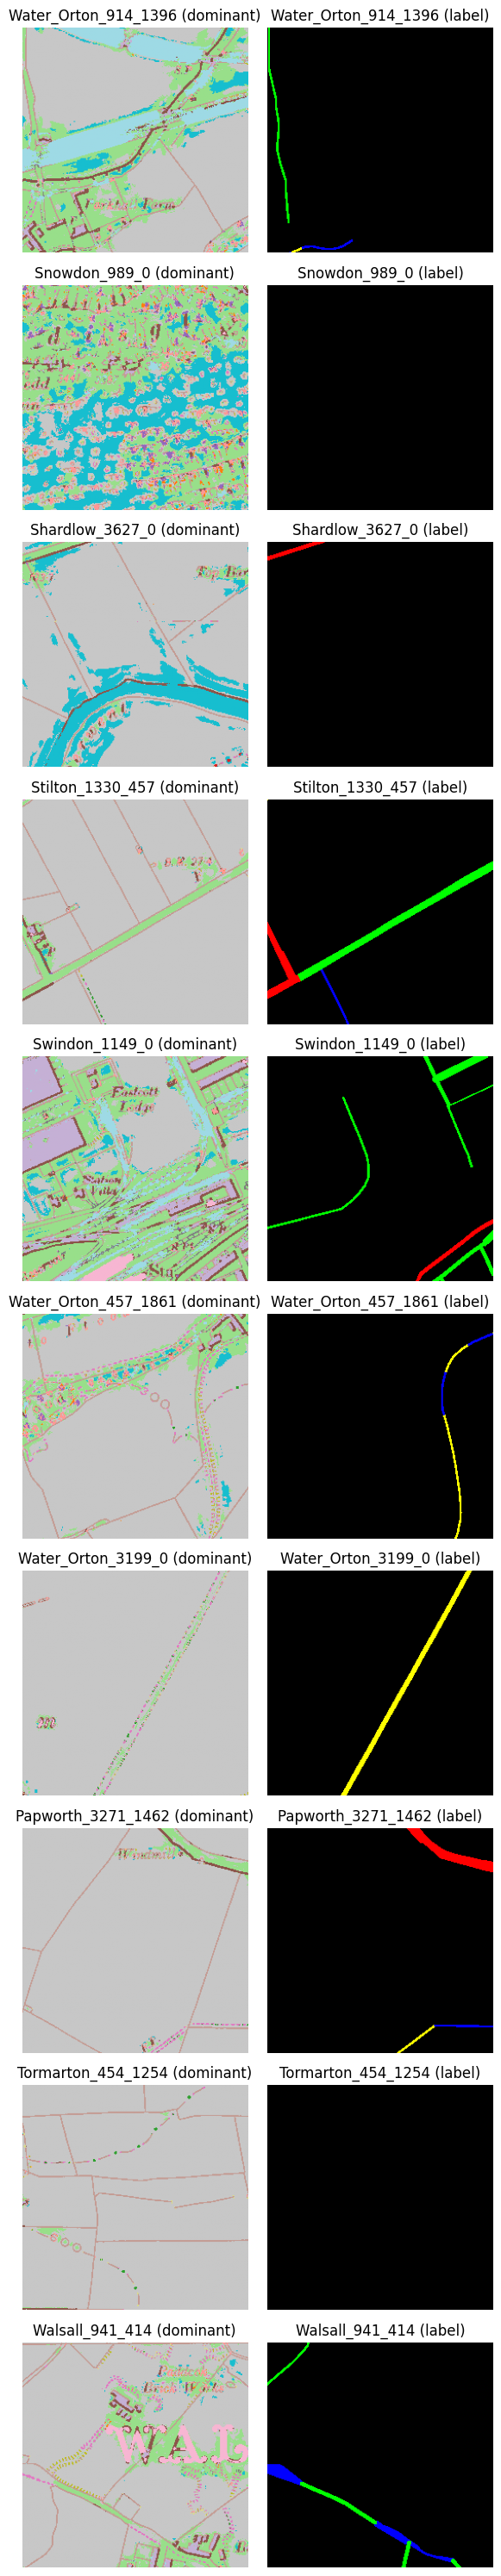

In [7]:
#@title Examine Sample Data

import os
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from skimage.transform import resize

# Get all .label.npy files
label_files = [f for f in os.listdir(tile_directory) if f.endswith('.label.npy')]

# Select a random sample of 60 images
sample_files = random.sample(label_files, min(10, len(label_files)))

# Define a custom colormap for labels
class_colors = [
    (0, 0, 0),      # 0: Black (background)
    (1, 0, 0),      # 1: Red
    (0, 1, 0),      # 2: Green
    (0, 0, 1),      # 3: Blue
    (1, 1, 0)       # 4: Yellow
]
cmap = ListedColormap(class_colors)

pseudo_cmap = ListedColormap(colormaps['tab20'].colors[:20])

# Set up a grid for displaying image-label pairs
num_cols = 2  # Image and label side by side
num_rows = len(sample_files)  # One row per pair
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 3 * num_rows))  # Smaller figure size

# Display each image-label pair
for i, file in enumerate(sample_files):
    label_path = os.path.join(tile_directory, file)
    image_path = label_path.replace(".label.npy", ".segformer_input.npy")
    title = file.replace(".label.npy", "")

    # Load and transpose input image
    img = np.load(image_path)
    if img.shape[0] == 21:
        img = np.transpose(img, (1, 2, 0))

    # Create pseudo-visualisation: dominant channel index (excluding last)
    pseudo_visual = np.argmax(img[:, :, :-1], axis=-1)  # shape (H, W)

    # Resize pseudo-visual and label
    pseudo_resized = resize(pseudo_visual, (256, 256), order=0, preserve_range=True).astype(np.uint8)
    label = np.load(label_path)
    label_resized = resize(label, (256, 256), anti_aliasing=False, order=0, preserve_range=True).astype(np.uint8)

    # Show pseudo-input
    axes[i, 0].imshow(pseudo_resized, cmap=pseudo_cmap, vmin=0, vmax=19)
    axes[i, 0].set_title(f"{title} (dominant)")
    axes[i, 0].axis("off")

    # Show actual label with your original colormap
    axes[i, 1].imshow(label_resized, cmap=cmap, vmin=0, vmax=4)
    axes[i, 1].set_title(f"{title} (label)")
    axes[i, 1].axis("off")

# Adjust layout and display
plt.tight_layout()
plt.show()
